Dinamic Portfolio Optimization: a quantitative comparison of portfolio strategies

1) Importare dataset da Excel (nella 3-4 riga ho reso le date, l'indice del mio dataset)

In [1]:
import pandas as pd
df = pd.read_excel(r"C:\Users\gabri\OneDrive\Desktop\Tesi\dataset_tesi_finale_definitivo.xlsx", sheet_name= 'Log_return',  engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.head())

            SPY_(ETF_SP500)  EEM_(Emergents_Market_ETF)  \
Date                                                      
2016-07-05        -0.721931                   -2.156265   
2016-07-06         0.598007                   -0.265452   
2016-07-07        -0.062045                   -0.266144   
2016-07-08         1.478094                    2.138650   
2016-07-11         0.352053                    0.951975   

            TLT_(Long_Period_Bond_ETF)  SHY_(Short_Period_Bond_ETF)  \
Date                                                                  
2016-07-05                    1.244250                     0.046900   
2016-07-06                    0.161493                    -0.046900   
2016-07-07                   -0.007001                    -0.046901   
2016-07-08                    0.733849                     0.000000   
2016-07-11                   -0.881342                    -0.105547   

            VNQ_(Real_Estate_ETF)  GLD_(ETF_GOLD)  USO_(ETF_OIL)  \
Date                

2) Dividere i dati in train e test

In [2]:
n = len(df)
split_index = int(0.8* n)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]
print(train_data.shape)
print(test_data.shape)

(1796, 8)
(450, 8)


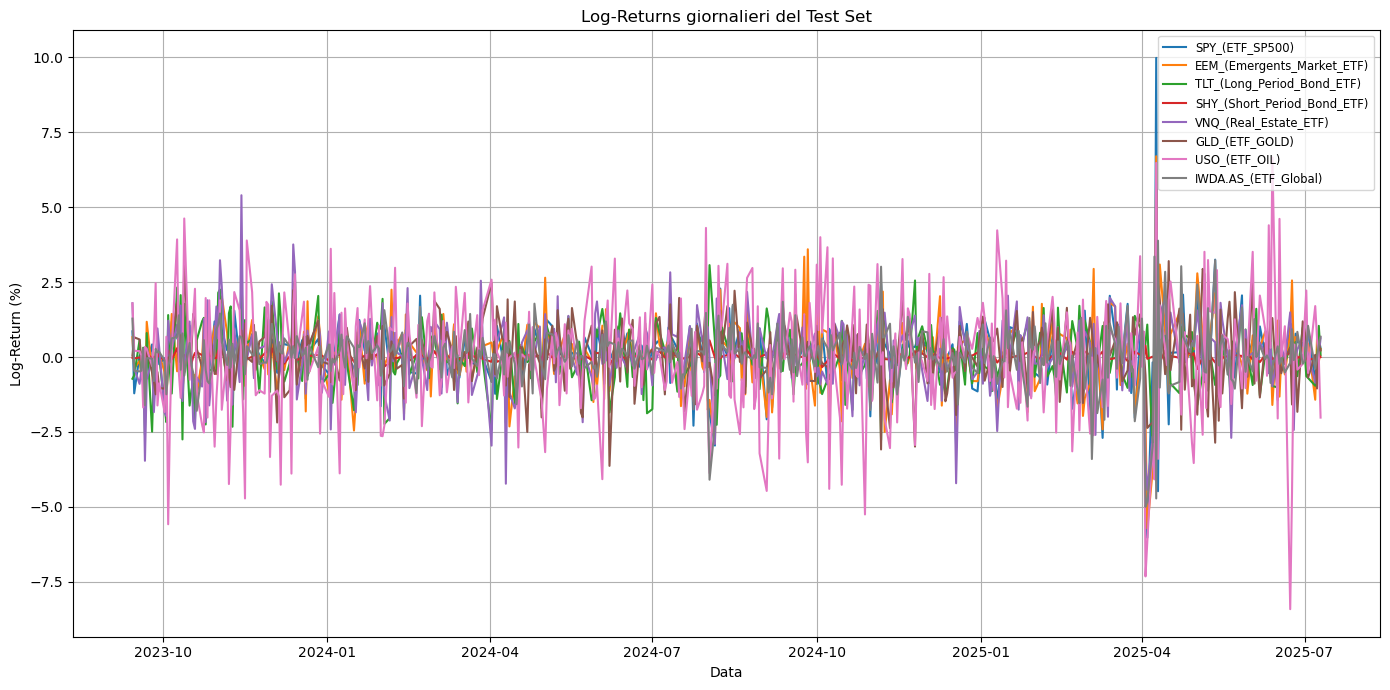

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for col in test_data.columns:
    plt.plot(test_data.index, test_data[col], label=col)

plt.title("Log-Returns giornalieri del Test Set")
plt.xlabel("Data")
plt.ylabel("Log-Return (%)")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

3. Verifichiamo che le serie siano stazionarie

In [4]:
from statsmodels.tsa.stattools import adfuller
for column in train_data.columns:
    series = train_data[column].dropna()
    
    if len(series) > 20:  # verifica che la serie abbia abbastanza dati
        result = adfuller(series)
        print(f" Serie: {column}")
        print(f" ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        if result[1] < 0.05:
            print(" Serie stazionaria (rifiuto H0)")
        else:
            print(" Serie non stazionaria (non rifiuto H0)")
        print("-" * 40)

 Serie: SPY_(ETF_SP500)
 ADF Statistic: -12.9750
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------
 Serie: EEM_(Emergents_Market_ETF)
 ADF Statistic: -15.8440
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------
 Serie: TLT_(Long_Period_Bond_ETF)
 ADF Statistic: -7.6346
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------
 Serie: SHY_(Short_Period_Bond_ETF)
 ADF Statistic: -8.4569
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------
 Serie: VNQ_(Real_Estate_ETF)
 ADF Statistic: -12.0146
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------
 Serie: GLD_(ETF_GOLD)
 ADF Statistic: -30.4744
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------
 Serie: USO_(ETF_OIL)
 ADF Statistic: -12.4923
p-value: 0.0000
 Serie stazionaria (rifiuto H0)
----------------------------------------

- Dopo il Test Dickey-Fuller possiamo attestre che tutte queste serie sono stazionarie (p-value < 0.05)

4. Ora possiamo procedere con la costruzione del modello Var

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)
from statsmodels.tsa.api import VAR
train_data.index.freq = pd.infer_freq(train_data.index) # Ricordiamo che stiamo lavorando con prezzi giornalieri
model_var = VAR(train_data) # Creazione del modello VAR
results = model_var.fit(ic='aic') # Stima automaticamente il Var con il lag che minimizza l'AIC
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Aug, 2025
Time:                     11:45:58
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -3.41451
Nobs:                     1787.00    HQIC:                  -4.54578
Log likelihood:          -15047.7    FPE:                 0.00547401
AIC:                     -5.20811    Det(Omega_mle):      0.00397373
--------------------------------------------------------------------
Results for equation SPY_(ETF_SP500)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.043210         0.027596            1.566           0.117
L1.SPY_(ETF_SP500)                    -0.134986         0.049790           -2.71

4) Ora creiamo un loop che mi consente di testare la causalità di Granger tra i dati di train, tra tutte le mie variabili.

In [6]:
variables = train_data.columns.tolist()
granger_results = []
for y in variables:
    for x in variables:
        if x !=y:
            test_result = results.test_causality(y, [x], kind= 'f')
            p_value = test_result.pvalue
            granger_results.append({'Cause':x, 'Effect':y, 'p-value':p_value})
            # esegui test: X -> Y
granger_df = pd.DataFrame(granger_results)
granger_df = granger_df.sort_values(by= 'p-value')
print(granger_df)

                          Cause                       Effect       p-value
49              SPY_(ETF_SP500)         IWDA.AS_(ETF_Global)  7.684191e-36
28              SPY_(ETF_SP500)        VNQ_(Real_Estate_ETF)  3.005479e-07
34         IWDA.AS_(ETF_Global)        VNQ_(Real_Estate_ETF)  5.507532e-07
7               SPY_(ETF_SP500)   EEM_(Emergents_Market_ETF)  4.986740e-06
37   TLT_(Long_Period_Bond_ETF)               GLD_(ETF_GOLD)  5.691260e-05
8    TLT_(Long_Period_Bond_ETF)   EEM_(Emergents_Market_ETF)  9.043782e-05
30   TLT_(Long_Period_Bond_ETF)        VNQ_(Real_Estate_ETF)  9.807375e-05
23   TLT_(Long_Period_Bond_ETF)  SHY_(Short_Period_Bond_ETF)  5.091842e-04
55                USO_(ETF_OIL)         IWDA.AS_(ETF_Global)  1.306351e-03
6          IWDA.AS_(ETF_Global)              SPY_(ETF_SP500)  1.402373e-03
50   EEM_(Emergents_Market_ETF)         IWDA.AS_(ETF_Global)  1.414796e-03
39        VNQ_(Real_Estate_ETF)               GLD_(ETF_GOLD)  1.525881e-03
33                USO_(ET

Recall: Granger Causality -> p_value < 0.05 <- Ipotesi è nulla, quindi x causa y

Ora andiamo a selezionare solo quelle che non soddisfano l'ipotesi di non causalità

In [7]:
significant_results = granger_df[granger_df['p-value'] < 0.06]
print(significant_results)

                          Cause                       Effect       p-value
49              SPY_(ETF_SP500)         IWDA.AS_(ETF_Global)  7.684191e-36
28              SPY_(ETF_SP500)        VNQ_(Real_Estate_ETF)  3.005479e-07
34         IWDA.AS_(ETF_Global)        VNQ_(Real_Estate_ETF)  5.507532e-07
7               SPY_(ETF_SP500)   EEM_(Emergents_Market_ETF)  4.986740e-06
37   TLT_(Long_Period_Bond_ETF)               GLD_(ETF_GOLD)  5.691260e-05
8    TLT_(Long_Period_Bond_ETF)   EEM_(Emergents_Market_ETF)  9.043782e-05
30   TLT_(Long_Period_Bond_ETF)        VNQ_(Real_Estate_ETF)  9.807375e-05
23   TLT_(Long_Period_Bond_ETF)  SHY_(Short_Period_Bond_ETF)  5.091842e-04
55                USO_(ETF_OIL)         IWDA.AS_(ETF_Global)  1.306351e-03
6          IWDA.AS_(ETF_Global)              SPY_(ETF_SP500)  1.402373e-03
50   EEM_(Emergents_Market_ETF)         IWDA.AS_(ETF_Global)  1.414796e-03
39        VNQ_(Real_Estate_ETF)               GLD_(ETF_GOLD)  1.525881e-03
33                USO_(ET

Ora selezioniamo solo le variabili che hanno un legame di causalità:
- SPY_(ETF_SP500) = 4
- IWDA.AS_(ETF_Global) = 5
- TLT_(Long_Period_Bond_ETF) = 4
- GLD_(ETF_GOLD) = 3
- SHY_(Short_Period_Bond_ETF) = 2
- VNQ_(Real_Estate_ETF) = 1
- USO_(ETF_OIL) = 3
- EEM_(Emergents_market_ETF) = 2

Da adesso lavorerò con due portafogli diversi:
1) Il primo sarà completo, quindi con tutte le variabili del mio dataset -> ptf_complete
2) Il secondo invece sarà composto solo dalle varibili che hanno una causalità maggiore (quindi escludendo -> SHY_(Short_Period_Bond_ETF) VNQ_(Real_estate_ETF) EEM_(Emergents_market_ETF) -> ptf_granger

In [8]:
ptf_complete = df
print(ptf_complete.head())
ptf_granger = df[['SPY_(ETF_SP500)','TLT_(Long_Period_Bond_ETF)', 'GLD_(ETF_GOLD)', 'USO_(ETF_OIL)',
       'IWDA.AS_(ETF_Global)']]
print(ptf_granger.head())

            SPY_(ETF_SP500)  EEM_(Emergents_Market_ETF)  \
Date                                                      
2016-07-05        -0.721931                   -2.156265   
2016-07-06         0.598007                   -0.265452   
2016-07-07        -0.062045                   -0.266144   
2016-07-08         1.478094                    2.138650   
2016-07-11         0.352053                    0.951975   

            TLT_(Long_Period_Bond_ETF)  SHY_(Short_Period_Bond_ETF)  \
Date                                                                  
2016-07-05                    1.244250                     0.046900   
2016-07-06                    0.161493                    -0.046900   
2016-07-07                   -0.007001                    -0.046901   
2016-07-08                    0.733849                     0.000000   
2016-07-11                   -0.881342                    -0.105547   

            VNQ_(Real_Estate_ETF)  GLD_(ETF_GOLD)  USO_(ETF_OIL)  \
Date                

Ora dividiamo sempre in train e test i due portafogli

In [9]:
train_data_ptf_complete = ptf_complete.iloc[:split_index]
train_data_ptf_granger = ptf_granger.iloc[:split_index]
test_data_ptf_complete = ptf_complete.iloc[split_index:]
test_data_ptf_granger = ptf_granger.iloc[split_index:]
print(train_data_ptf_complete.shape)
print(train_data_ptf_granger.shape)
print(test_data_ptf_complete.shape)
print(test_data_ptf_granger.shape)

(1796, 8)
(1796, 5)
(450, 8)
(450, 5)


Ora vado a calcolare i rendimenti degli ETF prima dei dati di train poi nel test:

In [10]:
import numpy as np
# Calcolo rendimento totale per ogni ETF
total_returns_train_ptf_complete = (np.exp(train_data_ptf_complete.sum() / 100) - 1) * 100
total_returns_test_ptf_complete = (np.exp(test_data_ptf_complete.sum() / 100) - 1) * 100
print("Ecco i rendimenti dei dati di train nel portafoglio completo:")
for etf, val in total_returns_train_ptf_complete.round(3).items():
    print(f"{etf}: {val}%")
print("Ecco i rendimenti dei dati di test nel portafoglio completo:")
for etf, val in total_returns_test_ptf_complete.round(3).items():
    print(f"{etf}: {val}%")

Ecco i rendimenti dei dati di train nel portafoglio completo:
SPY_(ETF_SP500): 140.569%
EEM_(Emergents_Market_ETF): 30.395%
TLT_(Long_Period_Bond_ETF): -21.229%
SHY_(Short_Period_Bond_ETF): 4.405%
VNQ_(Real_Estate_ETF): 20.041%
GLD_(ETF_GOLD): 37.902%
USO_(ETF_OIL): -15.45%
IWDA.AS_(ETF_Global): 110.746%
Ecco i rendimenti dei dati di test nel portafoglio completo:
SPY_(ETF_SP500): 43.889%
EEM_(Emergents_Market_ETF): 30.713%
TLT_(Long_Period_Bond_ETF): -0.509%
SHY_(Short_Period_Bond_ETF): 9.267%
VNQ_(Real_Estate_ETF): 20.635%
GLD_(ETF_GOLD): 72.916%
USO_(ETF_OIL): -5.384%
IWDA.AS_(ETF_Global): 29.622%


Ora utilizziamo solo i dati di test per calcolare volatilità annualizzata ,rendimento totale e annualizzato di entrambi i portafogli (Equally-Weighted)

In [11]:
weights_ptf_ew_complete = np.array([0.125] * 8)
log_returns_ptf_ew_complete = test_data_ptf_complete.dot(weights_ptf_ew_complete)  # log-return in %
total_return_ptf_ew_complete = (np.exp(log_returns_ptf_ew_complete.sum() / 100) - 1)
years = 450 / 252
# Rendimento annualizzato (in %)
annualized_return_ptf_ew_complete = ((total_return_ptf_ew_complete + 1) ** (1 / years) - 1) * 100
# Volatilità annualizzata (in %)
daily_vol_ptf_ew_complete = log_returns_ptf_ew_complete.std() / 100
annualized_vol_ptf_ew_complete = daily_vol_ptf_ew_complete * np.sqrt(252)

print(f"Rendimento totale del portafoglio completo: {total_return_ptf_ew_complete * 100:.3f}%")
print(f"Rendimento annualizzato del portafoglio completo: {annualized_return_ptf_ew_complete:.3f}%")
print(f"Volatilità annualizzata del portafoglio completo: {annualized_vol_ptf_ew_complete * 100:.3f}%")

Rendimento totale del portafoglio completo: 22.976%
Rendimento annualizzato del portafoglio completo: 12.279%
Volatilità annualizzata del portafoglio completo: 9.300%


In [12]:
weights_ptf_ew_granger = np.array([0.20] * 5)
log_returns_ptf_ew_granger = test_data_ptf_granger.dot(weights_ptf_ew_granger)  # log-return in %
total_return_ptf_ew_granger = (np.exp(log_returns_ptf_ew_granger.sum() / 100) - 1)
years = 450 / 252
# Rendimento annualizzato (in %)
annualized_return_ptf_ew_granger = ((total_return_ptf_ew_granger + 1) ** (1 / years) - 1) * 100
# Volatilità annualizzata (in %)
daily_vol_ptf_ew_granger = log_returns_ptf_ew_granger.std() / 100
annualized_vol_ptf_ew_granger = daily_vol_ptf_ew_granger * np.sqrt(252)

print(f"Rendimento totale del portafoglio di Granger: {total_return_ptf_ew_granger * 100:.3f}%")
print(f"Rendimento annualizzato del portafoglio di Granger: {annualized_return_ptf_ew_granger:.3f}%")
print(f"Volatilità annualizzata del portafoglio di Granger: {annualized_vol_ptf_ew_granger * 100:.3f}%")

Rendimento totale del portafoglio di Granger: 24.870%
Rendimento annualizzato del portafoglio di Granger: 13.244%
Volatilità annualizzata del portafoglio di Granger: 10.316%


- Possiamo notare che il portafoglio di Granger ha ottenuto un rendimento maggiore, ma sembra essere anche più volatile.

- Ora procediamo con lo sharpe ratio, ipotizzando un risk-free rate del 5.01 % (1-Year US Treasury Yield)

In [13]:
sharpe_ptf_complete = (12.27 - 5.01) / 9.30
print(f"Sharpe ratio del portafoglio completo: {sharpe_ptf_complete:.3f}")
sharpe_ptf_granger = (13.24 - 5.01) / 10.31
print(f"Sharpe ratio del portafoglio di Granger: {sharpe_ptf_granger:.3f}")

Sharpe ratio del portafoglio completo: 0.781
Sharpe ratio del portafoglio di Granger: 0.798


- Entrambi i portafogli mostrano uno Sharpe Ratio compreso tra 0.78 e 0.79, un valore che indica una performance moderata. Sebbene il rendimento annualizzato superi il tasso privo di rischio, il rapporto rischio/rendimento non risulta particolarmente efficiente. Pertanto, pur trattandosi di portafogli diversificati, sarebbe opportuno valutare strategie alternative per migliorare la gestione del rischio o l’allocazione degli asset.

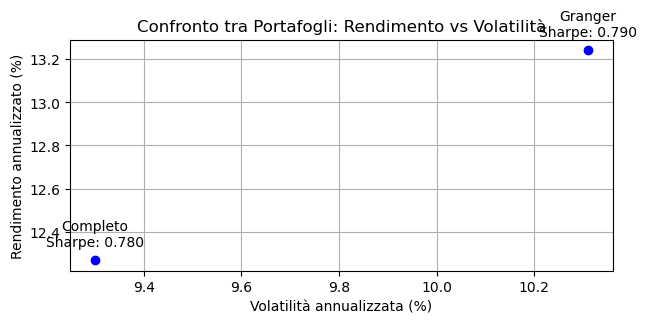

In [14]:
# Grafico
returns = [12.27, 13.24]
volatility = [9.30, 10.31]
labels = ['Completo','Granger']
sharpes = [0.78,0.79]

# Crea il grafico
plt.figure(figsize = (7,3))
plt.scatter(volatility,returns, color='blue')

for i in range(len(labels)):
    plt.annotate(f"{labels[i]}\nSharpe: {sharpes[i]:.3f}", 
                 (volatility[i], returns[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), ha='center')
# Etichette
plt.xlabel("Volatilità annualizzata (%)")
plt.ylabel("Rendimento annualizzato (%)")
plt.title("Confronto tra Portafogli: Rendimento vs Volatilità")
plt.grid(True)
plt.show()

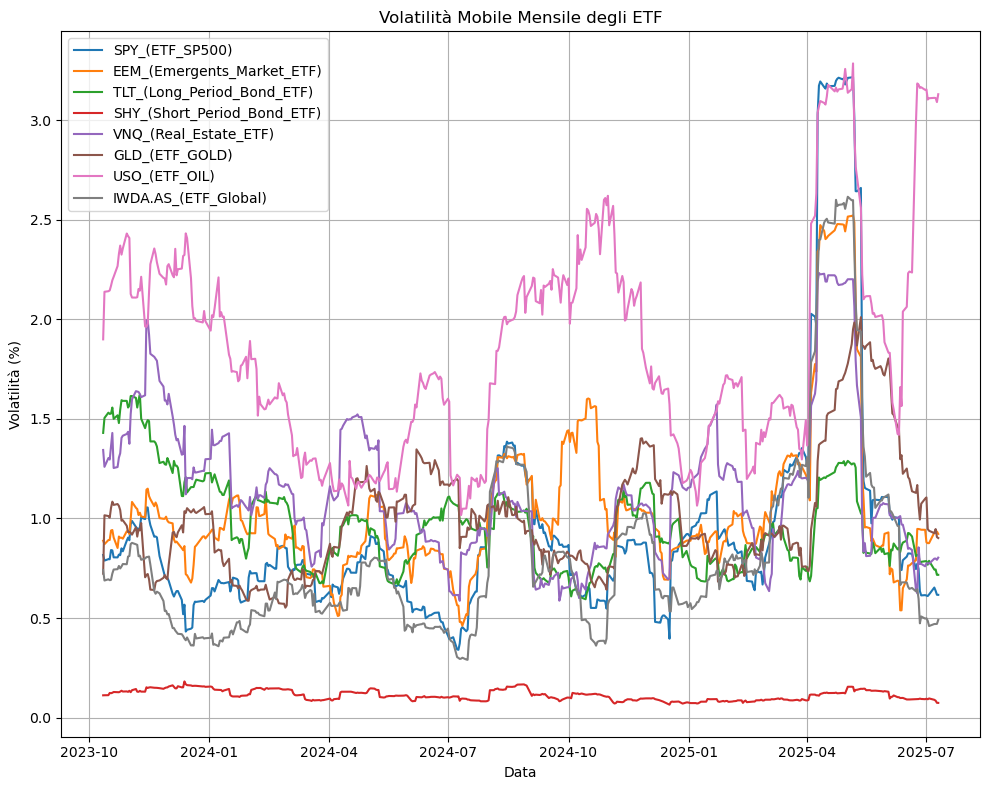

In [15]:
# Calcolo della volatilità mobile (21 giorni)
rolling_vol = test_data_ptf_complete.rolling(window=21).std()

# Plot
plt.figure(figsize=(10, 8))
for column in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[column], label=column)

plt.title("Volatilità Mobile Mensile degli ETF")
plt.xlabel("Data")
plt.ylabel("Volatilità (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Ora ipotizziamo di aver investito 10000 USD in entrambi i portafogli dal 2023, e vediamo l'andamento che hanno avuto i 10000 USD investiti

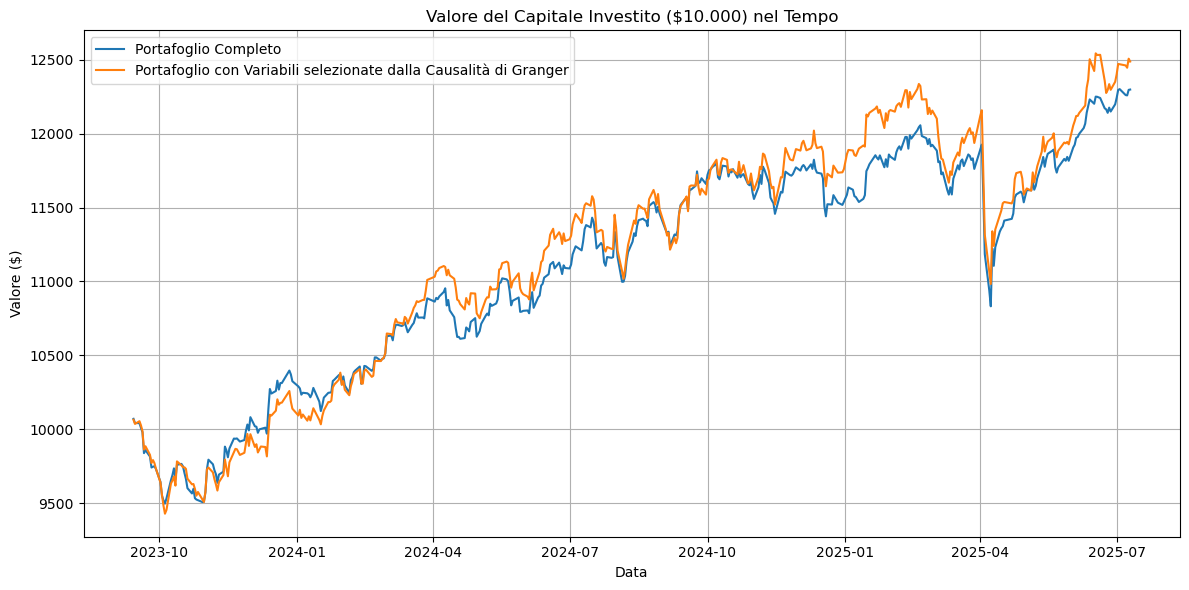

In [16]:
# Capitale iniziale
initial_value = 10000

# Conversione da percentuale a decimale
log_returns_complete_ew_decimal = log_returns_ptf_ew_complete / 100
log_returns_granger_ew_decimal = log_returns_ptf_ew_granger / 100
# Valore cumulato nel tempo
cum_returns_complete = np.exp(log_returns_complete_ew_decimal.cumsum())
value_complete = 10000 * cum_returns_complete
cum_returns_granger = np.exp(log_returns_granger_ew_decimal.cumsum())
value_granger = 10000 * cum_returns_granger

plt.figure(figsize=(12, 6))
plt.plot(value_complete, label='Portafoglio Completo')
plt.plot(value_granger, label='Portafoglio con Variabili selezionate dalla Causalità di Granger')
plt.title("Valore del Capitale Investito ($10.000) nel Tempo")
plt.xlabel("Data")
plt.ylabel("Valore ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Ora passiamo all'ottimizzazione di portafoglio con Markowitz, quindi proviamo a:
- Massimizzare il rendimento a parità di rischio
- Minimizzare la volatilità, a parità di rendimento atteso

In [17]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models, expected_returns
 
# Per l'ottimizzazione, i pesi devono essere calcolati solo sui dati di train, 
# e successivamente applicati al test per valutare la performance.
# Qualsiasi ottimizzazione fatta anche solo parzialmente sul test introduce bias e rende i risultati non affidabili. 

train_data_ptf_complete_not_prctg = train_data_ptf_complete / 100
train_data_ptf_granger_not_prctg = train_data_ptf_granger / 100

mean_return_annualized_train_complete = train_data_ptf_complete_not_prctg.mean() * 252
mean_return_annualized_train_granger = train_data_ptf_granger_not_prctg.mean() * 252

cov_matrix_train_complete = train_data_ptf_complete_not_prctg.cov() * 252
cov_matrix_train_granger = train_data_ptf_granger_not_prctg.cov() * 252

ef_train_complete = EfficientFrontier(mean_return_annualized_train_complete,cov_matrix_train_complete)
ef_train_granger = EfficientFrontier(mean_return_annualized_train_granger,cov_matrix_train_granger)

In [18]:
# Ora andiamo a calcolare i pesi ottimiali di ogni asset per massimizzare lo sharpe ratio
optimal_weights_train_complete = ef_train_complete.max_sharpe()
optimal_weights_train_granger = ef_train_granger.max_sharpe()

clean_optimal_weights_train_complete = ef_train_complete.clean_weights()
clean_optimal_weights_train_granger = ef_train_granger.clean_weights()

print("Pesi dati di train nel portafoglio completo:", clean_optimal_weights_train_complete)
print("Pesi dati di train nel portafoglio Granger:", clean_optimal_weights_train_granger)

Pesi dati di train nel portafoglio completo: OrderedDict({'SPY_(ETF_SP500)': 0.05369, 'EEM_(Emergents_Market_ETF)': 0.0, 'TLT_(Long_Period_Bond_ETF)': 0.0, 'SHY_(Short_Period_Bond_ETF)': 0.81975, 'VNQ_(Real_Estate_ETF)': 0.0, 'GLD_(ETF_GOLD)': 0.03253, 'USO_(ETF_OIL)': 0.0, 'IWDA.AS_(ETF_Global)': 0.09403})
Pesi dati di train nel portafoglio Granger: OrderedDict({'SPY_(ETF_SP500)': 0.24694, 'TLT_(Long_Period_Bond_ETF)': 0.0, 'GLD_(ETF_GOLD)': 0.33285, 'USO_(ETF_OIL)': 0.0, 'IWDA.AS_(ETF_Global)': 0.42022})


- Ecco i pesi ottimali per massimizzare lo sharpe ratio nel portafoglio completo:    
- SPY_(ETF_500) Train -> 5.36 %                                                     
- EEM_(Emergents_Market_ETF) Train -> 0.00                                        
- TLT_(log_Period_Bond_ETF) Train -> 0.00 % 
- SHY_(Short_Period_Bond_ETF)  Train -> 81.97 %                                     
- VNQ_(Real_Estate_ETF) = Train -> 0.00 %                                              
- GLD_(ETF_GOLD) Train -> 3.23 %                                                  
- USO_(ETF_OIL) Train -> 0.00 % 
- IWDA.AS_(ETF_Global) Train -> 9.40 % 

- Ecco i pesi ottimali per massimizzare lo sharpe ratio nei dati di test nel portafoglio di Granger:    
- SPY_(ETF_SP500) Train -> 24.69 
- TLT_(Long_Period_Bond_ETF) Train -> 0.00 % 
- GLD_(ETF_GOLD) = Train -> 33.28 
- USO_(ETF_OIL) = Train -> 0.0 % 
- IWDA.AS_(ETF_Global) = Train -> 42.02 

- Secondo questo metodo, possiamo notare che nel caso del portafoglio completo, per massimizzare lo sharpe ratio, si ha un esposizione molto alta sulle obbligazioni nel breve periodo, ciò ci fa capire che cerca costruire un portafoglio molto conservativo seppur non molto diversificato.
- Nel caso del portafoglio di Granger invece, ha un approccio più aggressivo, ma cercando comunque di mantenere una certa diversificazione

In [19]:
# Calcolo delle performance attese
perf_optimal_weights_train_complete = ef_train_complete.portfolio_performance(verbose=True)
perf_optimal_weights_train_granger = ef_train_granger.portfolio_performance(verbose=True)

Expected annual return: 2.3%
Annual volatility: 2.6%
Sharpe Ratio: 0.89
Expected annual return: 8.9%
Annual volatility: 11.2%
Sharpe Ratio: 0.80


In [20]:
# Ora utilizziamo i pesi ottimali ottenuti nei dati di train e li applichiamo ai dati di test per massimizzare lo sharpe ratio di un portafoglio
# 1
test_data_ptf_complete_not_prctg = test_data_ptf_complete / 100
test_data_ptf_granger_not_prctg = test_data_ptf_granger / 100

# 2
assets_complete = list(test_data_ptf_complete.columns)
weights_sharpe_complete = np.array([clean_optimal_weights_train_complete.get(asset, 0.0) for asset in assets_complete])
# dunque si crea la lista dei soli pesi seguendo l'ordine degli asset, se un asset non esiste nel dizionario gli diamo 0 come peso
assets_granger = list(test_data_ptf_granger.columns)
weights_sharpe_granger = np.array([clean_optimal_weights_train_granger.get(asset, 0.0) for asset in assets_granger]) 


# 3
portfolio_returns_sharpe_complete = test_data_ptf_complete_not_prctg.dot(weights_sharpe_complete)
portfolio_returns_sharpe_granger = test_data_ptf_granger_not_prctg.dot(weights_sharpe_granger)

# 4, 5 e 6
n_days_sharpe = portfolio_returns_sharpe_complete.shape[0]
years = n_days_sharpe / 252

cumulative_return_sharpe_complete = np.exp(portfolio_returns_sharpe_complete.sum()) - 1
annualized_return_sharpe_complete = (1 + cumulative_return_sharpe_complete)**(1 / years) - 1
annualized_vol_sharpe_complete = portfolio_returns_sharpe_complete.std() * np.sqrt(252)


cumulative_return_sharpe_granger = np.exp(portfolio_returns_sharpe_granger.sum()) - 1
annualized_return_sharpe_granger = (1 + cumulative_return_sharpe_granger)**(1 / years) - 1
annualized_vol_sharpe_granger = portfolio_returns_sharpe_granger.std() * np.sqrt(252)


print("Performance sul test set per massimizzare lo sharpe ratio:")
print(f"Portafoglio COMPLETO — Rendimento annualizzato: {annualized_return_sharpe_complete*100:.2f}%, Volatilità annualizzata: {annualized_vol_sharpe_complete*100:.2f}%")
print(f"Portafoglio GRANGER — Rendimento annualizzato: {annualized_return_sharpe_granger*100:.2f}%, Volatilità annualizzata: {annualized_vol_sharpe_granger*100:.2f}%")

Performance sul test set per massimizzare lo sharpe ratio:
Portafoglio COMPLETO — Rendimento annualizzato: 7.82%, Volatilità annualizzata: 2.42%
Portafoglio GRANGER — Rendimento annualizzato: 23.79%, Volatilità annualizzata: 10.19%


- Ora utilizziamo un altro modello di ottimizzazione per minimizzare la volatilità

In [21]:
ef_min_vol_train_complete = EfficientFrontier(mean_return_annualized_train_complete,cov_matrix_train_complete)
ef_min_vol_train_granger = EfficientFrontier(mean_return_annualized_train_granger,cov_matrix_train_granger)

optimal_weights_min_vol_train_complete = ef_min_vol_train_complete.min_volatility()
optimal_weights_min_vol_train_granger = ef_min_vol_train_granger.min_volatility()

clean_optimal_weights_min_vol_train_complete = ef_min_vol_train_complete.clean_weights()
clean_optimal_weights_min_vol_train_granger = ef_min_vol_train_granger.clean_weights()

print("Pesi dati di train nel portafoglio completo per minimizzare la volatilità:", clean_optimal_weights_min_vol_train_complete)
print("Pesi dati di train nel portafoglio granger per minimizzare la volatilità:", clean_optimal_weights_min_vol_train_granger)

Pesi dati di train nel portafoglio completo per minimizzare la volatilità: OrderedDict({'SPY_(ETF_SP500)': 0.0, 'EEM_(Emergents_Market_ETF)': 0.0, 'TLT_(Long_Period_Bond_ETF)': 0.0, 'SHY_(Short_Period_Bond_ETF)': 0.97562, 'VNQ_(Real_Estate_ETF)': 0.0, 'GLD_(ETF_GOLD)': 0.0, 'USO_(ETF_OIL)': 0.00336, 'IWDA.AS_(ETF_Global)': 0.02102})
Pesi dati di train nel portafoglio granger per minimizzare la volatilità: OrderedDict({'SPY_(ETF_SP500)': 0.08389, 'TLT_(Long_Period_Bond_ETF)': 0.32278, 'GLD_(ETF_GOLD)': 0.28274, 'USO_(ETF_OIL)': 0.01458, 'IWDA.AS_(ETF_Global)': 0.29601})


- Ecco i pesi ottimali per minimizzare la volatilità del portafoglio completo:
- SPY_(ETF_500) Train -> 0.00 % 
- EEM_(Emergents_Market_ETF) Train -> 0.00 % 
- TLT_(Long_Period_Bond_ETF) Train -> 0.00 % 
- SHY_(Short_Period_Bond_ETF) Train -> 97.56 %                                  
- VNQ_(Real_Estate_ETF) Train -> 0.00 %                                             
- GLD_(ETF_GOLD) Train -> 0.00 %                                                
- USO_(ETF_OIL) Train -> 3.36 % 
- IWDA.AS_(ETF_Global) Train -> 2.10 % 

- Ecco i pesi ottimali per minimizzare la volatilità del portafoglio di Granger:
- SPY_(ETF_SP500) Train -> 8.38 % 
- TLT_(Long_Period_Bond_ETF) Train -> 32.27 % 
- GLD_(ETF_GOLD) Train -> 28.27 % 
- USO_(ETF_OIL) Train -> 1.45 % 
- IWDA.AS_(ETF_Global) Train -> 29.60 % 

Come possiamo notare anche in questo caso, per minimizzare la volatilità del portafoglio completo, abbiamo un esposizione quasi del 100% sull'ETF del bond nel breve periodo.
Invece notando il portafoglio di Granger, siccome la variabile del bond nel breve periodo è stata eliminata eliminata, il portafoglio è ben diversificato, mantenedo comunque una volatilità bassa.

In [22]:
perf_optimal_weights_min_vol_train_complete = ef_min_vol_train_complete.portfolio_performance(verbose=True)
perf_optimal_weights_min_vol_train_granger = ef_min_vol_train_granger.portfolio_performance(verbose=True)

Expected annual return: 0.8%
Annual volatility: 1.5%
Sharpe Ratio: 0.54
Expected annual return: 4.3%
Annual volatility: 8.6%
Sharpe Ratio: 0.50


In [23]:
# Calcolo delle performance del portafoglio completo che minimizza la volatilità
weights_min_vol_complete = np.array([clean_optimal_weights_min_vol_train_complete.get(asset, 0.0) for asset in assets_complete])

log_returns_min_vol_complete = test_data_ptf_complete.dot(weights_min_vol_complete)  # log-return in %
total_return_ptf_min_vol_complete = (np.exp(log_returns_min_vol_complete.sum() / 100) - 1)
years = 450 / 252
# Rendimento annualizzato (in %)
annualized_return_ptf_min_vol_complete = ((total_return_ptf_min_vol_complete + 1) ** (1 / years) - 1) * 100
# Volatilità annualizzata (in %)
daily_vol_ptf_min_vol_complete = log_returns_min_vol_complete.std() / 100
annualized_vol_ptf_min_vol_complete = daily_vol_ptf_min_vol_complete * np.sqrt(252)

print(f"Rendimento totale del portafoglio completo: {total_return_ptf_min_vol_complete * 100:.3f}%")
print(f"Rendimento annualizzato del portafoglio completo: {annualized_return_ptf_min_vol_complete:.3f}%")
print(f"Volatilità annualizzata del portafoglio completo: {annualized_vol_ptf_min_vol_complete * 100:.3f}%")

Rendimento totale del portafoglio completo: 9.607%
Rendimento annualizzato del portafoglio completo: 5.271%
Volatilità annualizzata del portafoglio completo: 1.724%


In [24]:
# Calcolo delle performance del portafoglio di granger che minimizza la volatilità
weights_min_vol_granger = np.array([clean_optimal_weights_min_vol_train_granger.get(asset, 0.0) for asset in assets_granger]) 
log_returns_min_vol_granger = test_data_ptf_granger.dot(weights_min_vol_granger)  # log-return in %
total_return_ptf_min_vol_granger = (np.exp(log_returns_min_vol_granger.sum() / 100) - 1)
years = 450 / 252
# Rendimento annualizzato (in %)
annualized_return_ptf_min_vol_granger = ((total_return_ptf_min_vol_granger + 1) ** (1 / years) - 1) * 100
# Volatilità annualizzata (in %)
daily_vol_ptf_min_vol_granger = log_returns_min_vol_granger.std() / 100
annualized_vol_ptf_min_vol_granger = daily_vol_ptf_min_vol_granger * np.sqrt(252)

print(f"Rendimento totale del portafoglio completo: {total_return_ptf_min_vol_granger * 100:.3f}%")
print(f"Rendimento annualizzato del portafoglio completo: {annualized_return_ptf_min_vol_granger:.3f}%")
print(f"Volatilità annualizzata del portafoglio completo: {annualized_vol_ptf_min_vol_granger * 100:.3f}%")

Rendimento totale del portafoglio completo: 29.655%
Rendimento annualizzato del portafoglio completo: 15.655%
Volatilità annualizzata del portafoglio completo: 8.893%


Ricapitolando, questi sono i rendimenti e la volatilità di entrambi i portafogli, con pesi uguali:
- Rendimento annualizzato del portafoglio completo con pesi uguali: 12.2 %
- Volatilità annualizzata del portafoglio completo con pesi uguali : 9.3 %
- Rendimento annualizzato del portafoglio di Granger: 13.2 %
- Volatilità annualizzata del portafoglio di Granger: 10.3 %

Questi sono i rendimenti e le volatilità di entrambi i portafogli con i pesi ottimali per massimizzare lo sharpe ratio:
- Rendimento annualizzato del portafoglio completo che massimizza l'indice di Sharpe: 7.82 %
- Volatilità annualizzata del portafoglio di completo che massimizza l'indice di Sharpe: 2.42 %
- Rendimento annualizzato del portafoglio di Granger che massimizza l'indice di Sharpe: 23.79 %
- Volatilità annualizzata del portafoglio di Granger che massimizza l'indice di Sharpe: 10.19 %

E per ultimo, questi sono i rendimenti e le volatilità dei portafogli che minimizzano la volatilità:
- Rendimento annualizzato del portafoglio completo che minimizza la volatilità: 5.27 %
- Volatilità annualizzata del portafoglio completo che minimizza la volatilità: 1.72 %
- Rendimento annualizzato del portafoglio di Granger che minimizza la volatilità: 15.65 %
- Volatilità annualizzato del portafoglio di Granger che minimizza la volatilità: 8.89 %

A seguito di questa analisi possiamo dedurre che nele portafoglio completo, seppur il modello con pesi uguali ha ottenuto il rendimento più alto, la volatilità è altrettando alta. Per quanto riguarda il portafoglio di Granger, abbiamo ottenuto dei risultati sbalorditivi. Possiamo confrontare il portafoglio con pesi uguali con quello che massimizza la sharpe, a parità di volatilità il secondo ha quasi il doppio del rendimento. Per quanto riguarda quello che minimizza la volatilità è altrettanto valido siccome ottiene un rendimento leggermente più alto di quello con pesi uguali con una volatilità più bassa.

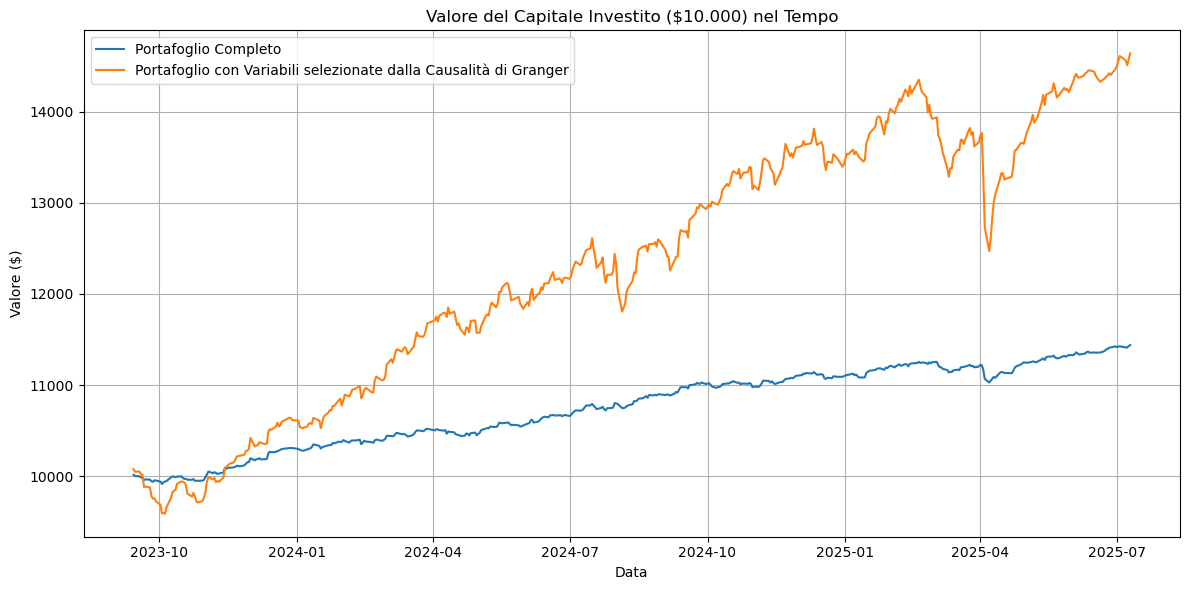

In [25]:
# pesi personalizzati (somma = 1)
weights_sharpe_complete = np.array([0.05369, 0.0, 0.0, 0.81975, 0.0, 0.03253, 0.0, 0.09403])  # 8 ETF
weights_sharpe_granger = np.array([0.24694, 0.0, 0.33285, 0.0, 0.42022])
log_returns_sharpe_ptf_complete_ = test_data_ptf_complete.dot(weights_sharpe_complete)  # log-return in %
log_returns_sharpe_ptf_granger = test_data_ptf_granger.dot(weights_sharpe_granger)  # log-return in %

log_returns_sharpe_ptf_complete_decimal = log_returns_sharpe_ptf_complete_ / 100
log_returns_sharpe_ptf_granger_decimal = log_returns_sharpe_ptf_granger / 100

initial_value = 10000

# Valore cumulato nel tempo
cum_returns_sharpe_complete = np.exp(log_returns_sharpe_ptf_complete_decimal.cumsum())
value_sharpe_complete = 10000 * cum_returns_sharpe_complete
cum_returns_sharpe_granger = np.exp(log_returns_sharpe_ptf_granger_decimal.cumsum())
value_sharpe_granger = 10000 * cum_returns_sharpe_granger

plt.figure(figsize=(12, 6))
plt.plot(value_sharpe_complete, label='Portafoglio Completo')
plt.plot(value_sharpe_granger, label='Portafoglio con Variabili selezionate dalla Causalità di Granger')
plt.title("Valore del Capitale Investito ($10.000) nel Tempo")
plt.xlabel("Data")
plt.ylabel("Valore ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

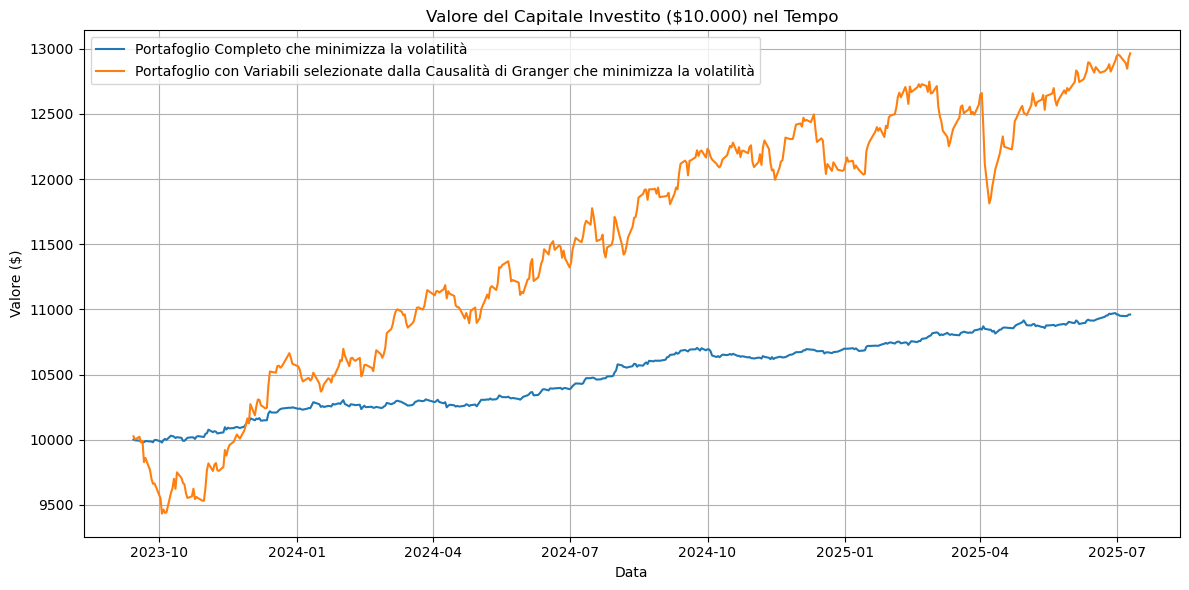

In [26]:
# pesi personalizzati (somma = 1)
weights_min_vol_complete = np.array([0.0, 0.0, 0.0, 0.97562, 0.0, 0.0, 0.00336, 0.02102])  # 8 ETF
weights_min_vol_granger = np.array([0.08389, 0.32278, 0.28274, 0.01458, 0.29601])
log_returns_min_vol_ptf_complete = test_data_ptf_complete.dot(weights_min_vol_complete)  # log-return in %
log_returns_min_vol_ptf_granger = test_data_ptf_granger.dot(weights_min_vol_granger)  # log-return in %

log_returns_min_vol_ptf_complete_decimal = log_returns_min_vol_ptf_complete / 100
log_returns_min_vol_ptf_granger_decimal = log_returns_min_vol_ptf_granger / 100

initial_value = 10000

# Valore cumulato nel tempo
cum_returns_min_vol_complete = np.exp(log_returns_min_vol_ptf_complete_decimal.cumsum())
value_min_vol_complete = 10000 * cum_returns_min_vol_complete
cum_returns_min_vol_granger = np.exp(log_returns_min_vol_ptf_granger_decimal.cumsum())
value_min_vol_granger = 10000 * cum_returns_min_vol_granger

plt.figure(figsize=(12, 6))
plt.plot(value_min_vol_complete, label='Portafoglio Completo che minimizza la volatilità')
plt.plot(value_min_vol_granger, label='Portafoglio con Variabili selezionate dalla Causalità di Granger che minimizza la volatilità')
plt.title("Valore del Capitale Investito ($10.000) nel Tempo")
plt.xlabel("Data")
plt.ylabel("Valore ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

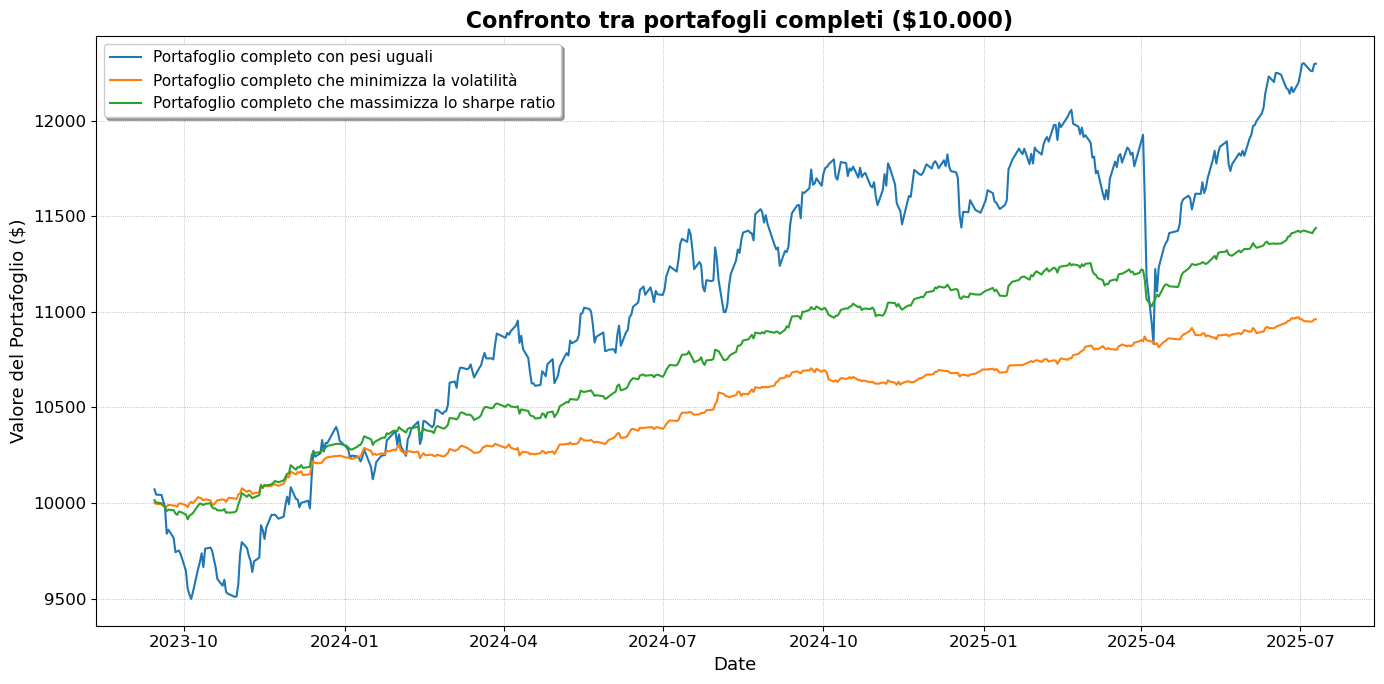

In [27]:
# Plot più complesso che contiene i tre grafici diversi
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default')
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 13

color_completo = '#1f77b4'

plt.figure(figsize =(14, 7))

# Ora mettiamo le linee di tutti e tre i portafogli
plt.plot(value_complete, label = 'Portafoglio completo con pesi uguali')
plt.plot(value_min_vol_complete, label = 'Portafoglio completo che minimizza la volatilità')
plt.plot(value_sharpe_complete, label = 'Portafoglio completo che massimizza lo sharpe ratio')
plt.title(" Confronto tra portafogli completi ($10.000)" , weight ='bold')
plt.xlabel('Date')
plt.ylabel('Valore del Portafoglio ($)')
plt.legend(loc='upper left', frameon = True, shadow = True , fontsize = 11)
plt.grid(True, linestyle =':', linewidth= 0.6)
plt.tight_layout()
plt.show()

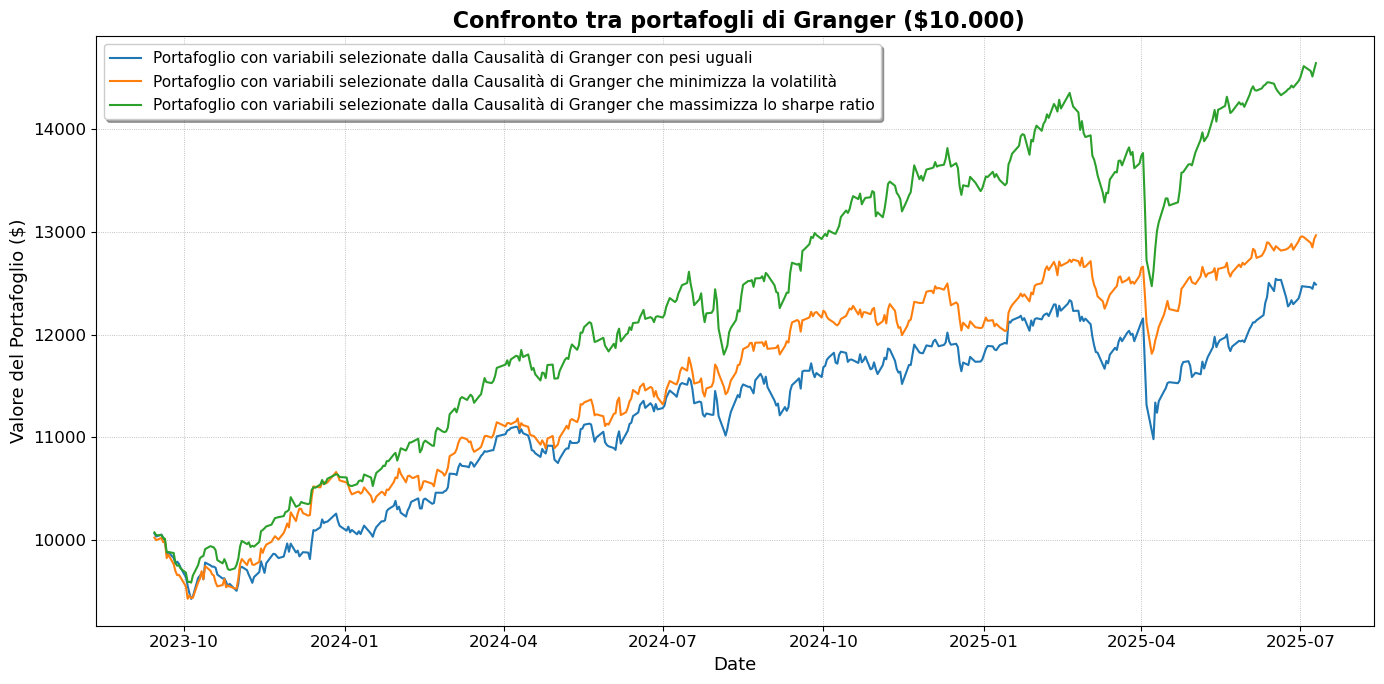

In [28]:
# Plot più complesso che contiene i tre grafici diversi
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default')
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 13

color_completo = '#ff7f0e'

plt.figure(figsize =(14, 7))

# Ora mettiamo le linee di tutti e tre i portafogli
plt.plot(value_granger, label = 'Portafoglio con variabili selezionate dalla Causalità di Granger con pesi uguali')
plt.plot(value_min_vol_granger, label = 'Portafoglio con variabili selezionate dalla Causalità di Granger che minimizza la volatilità')
plt.plot(value_sharpe_granger, label = 'Portafoglio con variabili selezionate dalla Causalità di Granger che massimizza lo sharpe ratio')
plt.title(" Confronto tra portafogli di Granger ($10.000)" , weight ='bold')
plt.xlabel('Date')
plt.ylabel('Valore del Portafoglio ($)')
plt.legend(loc='upper left', frameon = True, shadow = True , fontsize = 11)
plt.grid(True, linestyle =':', linewidth= 0.6)
plt.tight_layout()
plt.show()

Dopo aver utilizzato questi metodi di ottimizzazione possiamo passare al modello di Black-Litterman:

🔍 Cos’è il modello di Black‑Litterman?
Il modello è una forma avanzata di ottimizzazione Mean‑Variance (Markowitz) che supera diversi difetti pratici del MPT:
- l’altissima sensibilità alle stime di rendimento,
- la possibilità di produrre portafogli estremamente concentrati,
- la grande instabilità delle allocazioni se i parametri cambiano leggermente

L’idea centrale:
1) Parti da un rendimento atteso implicito di equilibrio del mercato (prior), basato su CAPM e sulle capitalizzazioni;
2) Poi aggiungi le tue “views” personali, espresse per alcuni asset (rimane opzionale);
3) In base alla fiducia nei tuoi view utilizzi un approccio bayesiano per ottenere un vettore di rendimento atteso aggiornato (posterior) 

In [29]:
import pandas as pd
price = pd.read_excel(r"C:\Users\gabri\OneDrive\Desktop\Tesi\dataset_tesi_finale_definitivo.xlsx", sheet_name= 'Price',  engine='openpyxl')
price['Date'] = pd.to_datetime(price['Date'])
price.set_index('Date', inplace=True)
n = len(price)
split_index = int(0.8* n)
train_data_price = price.iloc[:split_index]
test_data_price = price.iloc[split_index:]

ptf_complete_price = price[['SPY_(ETF_SP500)','EEM_(Emergents_Market_ETF)','TLT_(Long_Period_Bond_ETF)', 'SHY_(Short_Period_Bond_ETF)', 'VNQ_(Real_Estate_ETF)', 'GLD_(ETF_GOLD)', 'USO_(ETF_OIL)','IWDA.AS_(ETF_Global)']]
ptf_granger_price = price[['SPY_(ETF_SP500)','TLT_(Long_Period_Bond_ETF)', 'GLD_(ETF_GOLD)', 'USO_(ETF_OIL)',
       'IWDA.AS_(ETF_Global)']]
train_data_ptf_complete_price = ptf_complete_price.iloc[:split_index]
train_data_ptf_granger_price = ptf_granger_price.iloc[:split_index]
test_data_ptf_complete_price = ptf_complete_price.iloc[split_index:]
test_data_ptf_granger_price = ptf_granger_price.iloc[split_index:]
print(train_data_ptf_complete_price.shape)
print(train_data_ptf_granger_price.shape)
print(test_data_ptf_complete_price.shape)
print(test_data_ptf_granger_price.shape)

(1797, 8)
(1797, 5)
(450, 8)
(450, 5)


In [30]:
from pypfopt import BlackLittermanModel, EfficientFrontier, risk_models, expected_returns

# Step 1: Calcolo delle statistiche di base
mu_market_granger = expected_returns.capm_return(train_data_ptf_granger_price)
mu_market_complete = expected_returns.capm_return(train_data_ptf_complete_price)
# rendimenti attesi di mercato (CAPM)
S_granger = risk_models.sample_cov(train_data_ptf_granger_price)  # matrice di covarianza
S_complete = risk_models.sample_cov(train_data_ptf_complete_price)

In [31]:
# Step 2: Opinioni soggettive (esempio: GLD > SPY di 2%)
# Q = aspettative, P = struttura delle opinioni
Q_granger = np.array([0.15, 0.07, 0.02]) 
Q_complete = np.array([0.15, 0.07, 0.02, 0.05, 0.11])  # SPY, GLD, USO, EEM, IWDA
P_granger = np.zeros((3, len(train_data_ptf_granger_price.columns)))
P_complete = np.zeros((5, len(train_data_ptf_complete_price.columns)))
# Imposta le opinioni
P_granger[0, train_data_ptf_granger_price.columns.get_loc("SPY_(ETF_SP500)")] = 1
P_granger[1, train_data_ptf_granger_price.columns.get_loc("GLD_(ETF_GOLD)")] = 1
P_granger[2, train_data_ptf_granger_price.columns.get_loc("USO_(ETF_OIL)")] = 1

P_complete[0, train_data_ptf_complete_price.columns.get_loc("SPY_(ETF_SP500)")] = 1
P_complete[1, train_data_ptf_complete_price.columns.get_loc("GLD_(ETF_GOLD)")] = 1
P_complete[2, train_data_ptf_complete_price.columns.get_loc("USO_(ETF_OIL)")] = 1
P_complete[3, train_data_ptf_complete_price.columns.get_loc("EEM_(Emergents_Market_ETF)")] = 1
P_complete[4, train_data_ptf_complete_price.columns.get_loc("IWDA.AS_(ETF_Global)")] = 1

In [32]:
# Step 3: Costruzione del modello Black-Litterman
bl_complete = BlackLittermanModel(S_complete, pi=mu_market_complete, P =P_complete, Q=Q_complete)
bl_granger = BlackLittermanModel(S_granger, pi=mu_market_granger, P =P_granger, Q=Q_granger)
bl_mu_complete = bl_complete.bl_returns() # nuovi rendimenti attesi corretti
bl_mu_granger = bl_granger.bl_returns()

In [33]:

# Step 4: Ottimizzazione con Efficient Frontier
# Aggiungi un seed per sicurezza
ef_complete = EfficientFrontier(bl_mu_complete, S_complete)
ef_granger = EfficientFrontier(bl_mu_granger, S_granger)
weights_complete = ef_complete.max_sharpe()  # puoi anche fare ef.min_volatility()
weights_granger = ef_granger.max_sharpe()
cleaned_weights_complete = ef_complete.clean_weights()
cleaned_weights_granger = ef_granger.clean_weights()
print("Pesi ottimizzati portafoglio completo (Black-Litterman):")
print(cleaned_weights_complete)
print("Pesi ottimizzati portafoglio di granger (Black-Litterman):")
print(cleaned_weights_granger)

Pesi ottimizzati portafoglio completo (Black-Litterman):
OrderedDict({'SPY_(ETF_SP500)': 0.21054, 'EEM_(Emergents_Market_ETF)': 0.0, 'TLT_(Long_Period_Bond_ETF)': 0.07703, 'SHY_(Short_Period_Bond_ETF)': 0.09582, 'VNQ_(Real_Estate_ETF)': 0.07849, 'GLD_(ETF_GOLD)': 0.26762, 'USO_(ETF_OIL)': 0.01217, 'IWDA.AS_(ETF_Global)': 0.25831})
Pesi ottimizzati portafoglio di granger (Black-Litterman):
OrderedDict({'SPY_(ETF_SP500)': 0.35335, 'TLT_(Long_Period_Bond_ETF)': 0.14057, 'GLD_(ETF_GOLD)': 0.31792, 'USO_(ETF_OIL)': 0.04759, 'IWDA.AS_(ETF_Global)': 0.14057})


In [34]:
# Step 5: Performance
performance_bl_complete = ef_complete.portfolio_performance(verbose=True)
performance_bl_granger = ef_granger.portfolio_performance(verbose=True)

Expected annual return: 6.4%
Annual volatility: 9.6%
Sharpe Ratio: 0.67
Expected annual return: 6.8%
Annual volatility: 10.3%
Sharpe Ratio: 0.66


In [35]:
# 1. Convertiamo i log-return in formato decimale (se test_data è in %)
test_data_granger_bl = test_data_ptf_granger_price.pct_change().dropna()
test_data_complete_bl = test_data_ptf_complete_price.pct_change().dropna()

# 2. Ordiniamo i pesi del portafoglio Black-Litterman secondo l’ordine delle colonne
assets_granger_bl = list(test_data_granger_bl.columns)
assets_complete_bl = list(test_data_complete_bl.columns)

weights_granger_bl = np.array([cleaned_weights_granger.get(asset, 0.0) for asset in assets_granger_bl])
weights_complete_bl = np.array([cleaned_weights_complete.get(asset, 0.0) for asset in assets_complete_bl])

# 3. Calcoliamo i log-returns del portafoglio nel test set
portfolio_returns_granger_bl = test_data_granger_bl.dot(weights_granger_bl)
portfolio_returns_complete_bl = test_data_complete_bl.dot(weights_complete_bl)

# 4. Performance cumulative e annualizzate
n_days_granger = portfolio_returns_granger_bl.shape[0]
n_days_complete = portfolio_returns_complete_bl.shape[0]
years_granger = n_days_granger / 252
years_complete = n_days_complete / 252


cumulative_return_granger_bl = (1 + portfolio_returns_granger_bl).prod() - 1
cumulative_return_complete_bl = (1 + portfolio_returns_complete_bl).prod() - 1

annualized_return_granger_bl = (1 + cumulative_return_granger_bl)**(1 / years_granger) - 1
annualized_return_complete_bl = (1 + cumulative_return_complete_bl)**(1 / years_complete) - 1

annualized_vol_granger_bl = portfolio_returns_granger_bl.std() * np.sqrt(252)
annualized_vol_complete_bl = portfolio_returns_complete_bl.std() * np.sqrt(252)

# 5. Output
print("📈 Performance del portafoglio completo Black-Litterman sul test set:")
print(f"Rendimento annualizzato: {annualized_return_complete_bl * 100:.2f}%")
print(f"Volatilità annualizzata: {annualized_vol_complete_bl * 100:.2f}%")

print("📈 Performance del portafoglio di Granger Black-Litterman sul test set:")
print(f"Rendimento annualizzato: {annualized_return_granger_bl * 100:.2f}%")
print(f"Volatilità annualizzata: {annualized_vol_granger_bl * 100:.2f}%")


📈 Performance del portafoglio completo Black-Litterman sul test set:
Rendimento annualizzato: 19.73%
Volatilità annualizzata: 8.79%
📈 Performance del portafoglio di Granger Black-Litterman sul test set:
Rendimento annualizzato: 21.57%
Volatilità annualizzata: 10.09%


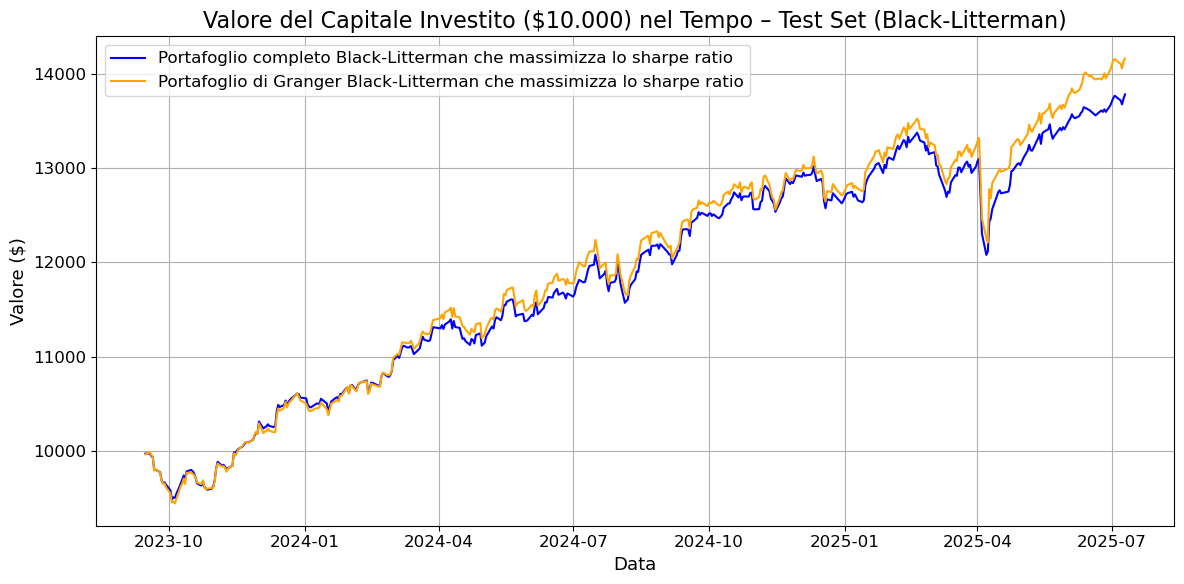

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Calcolo del valore cumulativo del portafoglio Black-Litterman
initial_cap = 10000
cum_returns_complete_bl = (1 + portfolio_returns_complete_bl).cumprod()
value_complete_bl = initial_cap * cum_returns_complete_bl
cum_returns_granger_bl = (1 + portfolio_returns_granger_bl).cumprod()
value_granger_bl = initial_cap * cum_returns_granger_bl

# Plot
plt.figure(figsize=(12, 6))
plt.plot(value_complete_bl, label='Portafoglio completo Black-Litterman che massimizza lo sharpe ratio', color='blue')
plt.plot(value_granger_bl, label='Portafoglio di Granger Black-Litterman che massimizza lo sharpe ratio', color='orange')
plt.title("Valore del Capitale Investito ($10.000) nel Tempo – Test Set (Black-Litterman)")
plt.xlabel("Data")
plt.ylabel("Valore ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Ora calcoliamo il BL per minimizzare la volatilità

In [37]:
# Step 4: Ottimizzazione con Efficient Frontier
# Aggiungi un seed per sicurezza
ef_complete = EfficientFrontier(bl_mu_complete, S_complete)
ef_granger = EfficientFrontier(bl_mu_granger, S_granger)
weights_complete_min_vol = ef_complete.min_volatility()  # puoi anche fare ef.min_volatility()
weights_granger_min_vol = ef_granger.min_volatility()
cleaned_weights_complete_min_vol = ef_complete.clean_weights()
cleaned_weights_granger_min_vol = ef_granger.clean_weights()
print("Pesi ottimizzati portafoglio completo (Black-Litterman):")
print(cleaned_weights_complete_min_vol)
print("Pesi ottimizzati portafoglio di granger (Black-Litterman):")
print(cleaned_weights_granger_min_vol)

Pesi ottimizzati portafoglio completo (Black-Litterman):
OrderedDict({'SPY_(ETF_SP500)': 0.0, 'EEM_(Emergents_Market_ETF)': 0.0, 'TLT_(Long_Period_Bond_ETF)': 0.0, 'SHY_(Short_Period_Bond_ETF)': 0.97539, 'VNQ_(Real_Estate_ETF)': 0.0, 'GLD_(ETF_GOLD)': 0.0, 'USO_(ETF_OIL)': 0.0034, 'IWDA.AS_(ETF_Global)': 0.02121})
Pesi ottimizzati portafoglio di granger (Black-Litterman):
OrderedDict({'SPY_(ETF_SP500)': 0.0836, 'TLT_(Long_Period_Bond_ETF)': 0.32241, 'GLD_(ETF_GOLD)': 0.28074, 'USO_(ETF_OIL)': 0.01727, 'IWDA.AS_(ETF_Global)': 0.29597})


In [38]:
# Step 5: Performance
performance_bl_complete_min_vol= ef_complete.portfolio_performance(verbose=True)
performance_bl_granger_min_vol = ef_granger.portfolio_performance(verbose=True)

Expected annual return: 0.3%
Annual volatility: 1.5%
Sharpe Ratio: 0.23
Expected annual return: 4.7%
Annual volatility: 8.6%
Sharpe Ratio: 0.55


In [39]:
weights_granger_bl_min_vol = np.array([cleaned_weights_granger_min_vol.get(asset, 0.0) for asset in assets_granger_bl])
weights_complete_bl_min_vol = np.array([cleaned_weights_complete_min_vol.get(asset, 0.0) for asset in assets_complete_bl])

# 3. Calcoliamo i log-returns del portafoglio nel test set
portfolio_returns_granger_bl_min_vol = test_data_granger_bl.dot(weights_granger_bl_min_vol)
portfolio_returns_complete_bl_min_vol = test_data_complete_bl.dot(weights_complete_bl_min_vol)

# 4. Performance cumulative e annualizzate
n_days_granger_min_vol = portfolio_returns_granger_bl_min_vol.shape[0]
n_days_complete_min_vol = portfolio_returns_complete_bl_min_vol.shape[0]
years_granger_min_vol = n_days_granger_min_vol / 252
years_complete_min_vol = n_days_complete_min_vol / 252


cumulative_return_granger_bl_min_vol = (1 + portfolio_returns_granger_bl_min_vol).prod() - 1
cumulative_return_complete_bl_min_vol = (1 + portfolio_returns_complete_bl_min_vol).prod() - 1

annualized_return_granger_bl_min_vol = (1 + cumulative_return_granger_bl_min_vol)**(1 / years_granger_min_vol) - 1
annualized_return_complete_bl_min_vol = (1 + cumulative_return_complete_bl_min_vol)**(1 / years_complete_min_vol) - 1

annualized_vol_granger_bl_min_vol = portfolio_returns_granger_bl_min_vol.std() * np.sqrt(252)
annualized_vol_complete_bl_min_vol = portfolio_returns_complete_bl_min_vol.std() * np.sqrt(252)

# 5. Output
print("📈 Performance del portafoglio completo Black-Litterman che minimizza la volatilità sul test set:")
print(f"Rendimento annualizzato: {annualized_return_complete_bl_min_vol * 100:.2f}%")
print(f"Volatilità annualizzata: {annualized_vol_complete_bl_min_vol * 100:.2f}%")

print("📈 Performance del portafoglio di Granger Black-Litterman che minimizza la volatilità sul test set:")
print(f"Rendimento annualizzato: {annualized_return_granger_bl_min_vol * 100:.2f}%")
print(f"Volatilità annualizzata: {annualized_vol_granger_bl_min_vol * 100:.2f}%")


📈 Performance del portafoglio completo Black-Litterman che minimizza la volatilità sul test set:
Rendimento annualizzato: 5.32%
Volatilità annualizzata: 1.73%
📈 Performance del portafoglio di Granger Black-Litterman che minimizza la volatilità sul test set:
Rendimento annualizzato: 16.46%
Volatilità annualizzata: 8.87%


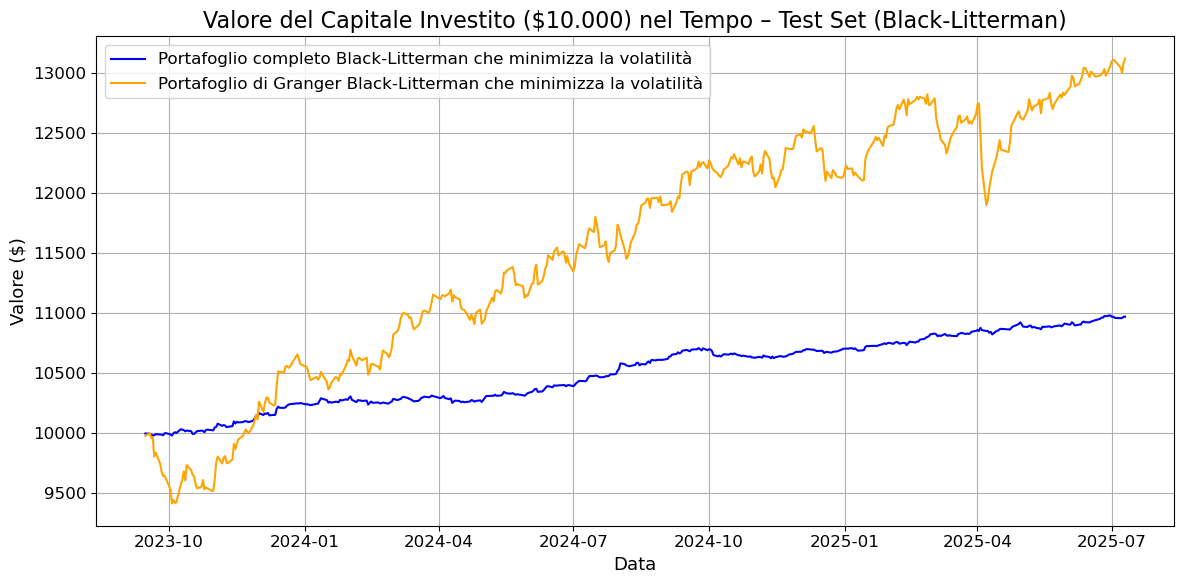

In [40]:
# Calcolo del valore cumulativo del portafoglio Black-Litterman
initial_cap = 10000
cum_returns_complete_bl_min_vol = (1 + portfolio_returns_complete_bl_min_vol).cumprod()
value_complete_bl_min_vol = initial_cap * cum_returns_complete_bl_min_vol
cum_returns_granger_bl_min_vol = (1 + portfolio_returns_granger_bl_min_vol).cumprod()
value_granger_bl_min_vol = initial_cap * cum_returns_granger_bl_min_vol

# Plot
plt.figure(figsize=(12, 6))
plt.plot(value_complete_bl_min_vol, label='Portafoglio completo Black-Litterman che minimizza la volatilità', color='blue')
plt.plot(value_granger_bl_min_vol, label='Portafoglio di Granger Black-Litterman che minimizza la volatilità', color='orange')
plt.title("Valore del Capitale Investito ($10.000) nel Tempo – Test Set (Black-Litterman)")
plt.xlabel("Data")
plt.ylabel("Valore ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Ora calcoliamo il Var e Cvar sul portafoglio completo e di granger Equally-Weighted

In [41]:
# === VaR / CVaR ANNUALE (empirico, rolling) – EW completo ===
import numpy as np
import pandas as pd

confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_ew_complete = pd.Series(log_returns_ptf_ew_complete).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_ew_complete.abs().median() > 0.2:
    s_ew_complete = s_ew_complete / 100.0

ann_log = s_ew_complete.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 199  |  % finestre con rendimento annuo < 0: 0.5%
VaR annuale 95% (return): 6.12%
CVaR annuale 95% (return medio in coda): 2.91%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


- Il portafoglio EW è molto stabile e mostra solo 1 finestra con rendimento negativo, anche nel peggiore dei casi il rendimento è positivo e di conseguenza non ri registrano perdite nel 95 % dei casi, quindi provo ad aumentare l'intervallo di confidenza

In [42]:
# === VaR/CVaR annuale a più livelli di confidenza === EW complete
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 6.12%   |   CVaR (return): 2.91%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 1.88%   |   CVaR (return): 0.09%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 0.68%   |   CVaR (return): -0.52%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.52%


- Ora possiamo notare che il Var non scende mai sotto lo zero, ciò siginifica che non c'è una soglia di perdita certa nemmeno al 99.5 % dei casi.
- Il CVaR negativo al 99.5 % significa che se entriamo nella coda estrema possiamo aspettarci una perdita media dello 0.52 %

In [43]:
# === VaR / CVaR ANNUALE (empirico, rolling) – EW granger ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_ew_granger = pd.Series(log_returns_ptf_ew_granger).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_ew_granger.abs().median() > 0.2:
    s_ew_granger = s_ew_granger / 100.0

ann_log = s_ew_granger.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 199  |  % finestre con rendimento annuo < 0: 0.5%
VaR annuale 95% (return): 4.61%
CVaR annuale 95% (return medio in coda): 2.38%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


- Granger batte Complete: rendimento più alto, rischio leggermente maggiore, ma VaR/CVaR più bassi di conseguenza la selezione causale migliora la qualità del rischio

In [44]:
# === VaR/CVaR annuale a più livelli di confidenza === EW granger
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 4.61%   |   CVaR (return): 2.38%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 1.33%   |   CVaR (return): -0.24%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.24%

Conf 99%:
  VaR (return): 0.28%   |   CVaR (return): -0.77%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.77%


In [45]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Markowitz (> sharpe ratio) completo ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_sharpe_complete = pd.Series(portfolio_returns_sharpe_complete).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_sharpe_complete.abs().median() > 0.2:
    s_sharpe_complete = s_sharpe_complete / 100.0

ann_log = s_sharpe_complete.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 199  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 6.21%
CVaR annuale 95% (return medio in coda): 5.62%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


- Questo portafoglio ha volatilità bassissima ma CVaR quasi uguale al VaR quindi il rischio concentrato in eventi rari.

In [46]:
# === VaR/CVaR annuale a più livelli di confidenza === Markowitz (> sharpe ratio) completo -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 6.21%   |   CVaR (return): 5.62%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 5.19%   |   CVaR (return): 5.06%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 5.11%   |   CVaR (return): 5.01%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [47]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Markowitz (> sharpe ratio) granger ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_sharpe_granger = pd.Series(portfolio_returns_sharpe_granger).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_sharpe_granger.abs().median() > 0.2:
    s_sharpe_granger = s_sharpe_granger / 100.0

ann_log = s_sharpe_granger.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 199  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 13.34%
CVaR annuale 95% (return medio in coda): 10.40%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


- Il portafolgio di Granger invece esplode in termini di rendimento ma con rischio elevato quindi ottimo profilo per chi accetta volatilità.

In [48]:
# === VaR/CVaR annuale a più livelli di confidenza === Markowitz (> sharpe ratio) granger -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 13.34%   |   CVaR (return): 10.40%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 8.95%   |   CVaR (return): 6.96%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 7.41%   |   CVaR (return): 6.51%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [49]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Markowitz (< volatilità) complete ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_min_vol_complete = pd.Series(log_returns_min_vol_ptf_complete_decimal).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_min_vol_complete.abs().median() > 0.2:
    s_min_vol_complete = s_min_vol_complete / 100.0

ann_log = s_min_vol_complete.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 199  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 4.43%
CVaR annuale 95% (return medio in coda): 4.37%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


- Questo portafolgio a differenza del precedente completo è ultra conservativo: bassa volatilità, CVaR ≈ VaR quindi il rischio distribuito.

In [50]:
# === VaR/CVaR annuale a più livelli di confidenza === Markowitz (< volatilità) complete -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 4.43%   |   CVaR (return): 4.37%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 4.36%   |   CVaR (return): 4.22%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 4.23%   |   CVaR (return): 4.22%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [51]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Markowitz (< volatilità) granger ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_min_vol_granger = pd.Series(log_returns_min_vol_ptf_granger_decimal).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_min_vol_granger.abs().median() > 0.2:
    s_min_vol_granger = s_min_vol_granger / 100.0

ann_log = s_min_vol_granger.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 199  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 10.66%
CVaR annuale 95% (return medio in coda): 8.45%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


- Mentre quello di Granger ha rendimento maggiore, rischio più alto ma ben gestito, ottimo compromesso.

In [52]:
# === VaR/CVaR annuale a più livelli di confidenza === Markowitz (< volatilità) granger -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 10.66%   |   CVaR (return): 8.45%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 7.19%   |   CVaR (return): 6.38%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 6.41%   |   CVaR (return): 6.36%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [53]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Black-Litterman (> sharpe ratio) complete ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_bl_complete = pd.Series(portfolio_returns_complete_bl).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_bl_complete.abs().median() > 0.2:
    s_bl_complete = s_bl_complete / 100.0

ann_log = s_bl_complete.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 198  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 13.35%
CVaR annuale 95% (return medio in coda): 10.70%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


In [54]:
# === VaR/CVaR annuale a più livelli di confidenza === Black-Litterman (> sharpe ratio) complete -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 13.35%   |   CVaR (return): 10.70%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 9.21%   |   CVaR (return): 7.38%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 7.39%   |   CVaR (return): 7.37%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [55]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Black-Litterman (> sharpe ratio) granger ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_bl_granger = pd.Series(portfolio_returns_granger_bl).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_bl_granger.abs().median() > 0.2:
    s_bl_granger = s_bl_granger / 100.0

ann_log = s_bl_granger.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 198  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 14.54%
CVaR annuale 95% (return medio in coda): 11.66%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


In [56]:
# === VaR/CVaR annuale a più livelli di confidenza === Black-Litterman (> sharpe ratio) garnger -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    # VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 14.54%   |   CVaR (return): 11.66%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 10.03%   |   CVaR (return): 7.63%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 8.01%   |   CVaR (return): 7.25%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [57]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Black-Litterman (< volatilità) complete ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_bl_min_vol_complete = pd.Series(portfolio_returns_complete_bl_min_vol).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_bl_min_vol_complete.abs().median() > 0.2:
    s_bl_min_vol_complete = s_bl_min_vol_complete / 100.0

ann_log = s_bl_min_vol_complete.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 198  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 4.48%
CVaR annuale 95% (return medio in coda): 4.41%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


In [58]:
# === VaR/CVaR annuale a più livelli di confidenza === Black-Litterman (< volatilità) complete -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    # VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 4.48%   |   CVaR (return): 4.41%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 4.41%   |   CVaR (return): 4.27%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 4.28%   |   CVaR (return): 4.27%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


In [59]:
# === VaR / CVaR ANNUALE (empirico, rolling) – Black-Litterman (< volatilità) granger ===
confidence_level = 0.95
alpha   = 1 - confidence_level   # es. 0.05
horizon = 252

s_bl_min_vol_granger = pd.Series(portfolio_returns_granger_bl_min_vol).dropna()
# Se i log-returns fossero in %, scala in decimali
if s_bl_min_vol_granger.abs().median() > 0.2:
    s_bl_min_vol_granger = s_bl_min_vol_granger / 100.0

ann_log = s_bl_min_vol_granger.rolling(horizon).sum().dropna()
if ann_log.empty:
    raise ValueError("Serie troppo corta per VaR/CVaR annuali (≥252 osservazioni).")

VaR_log  = np.quantile(ann_log.values, alpha)               # 5° percentile dei rendimenti log annuali
CVaR_log = ann_log[ann_log <= VaR_log].mean()               # media condizionata in coda

# --- Spazio rendimenti (più intuitivo quando la coda è positiva) ---
VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100

# --- Spazio perdite (cappato a 0 perché non può esserci perdita se il rendimento è >0) ---
VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

# Quante finestre annuali hanno rendimento negativo?
pct_neg = (ann_log < 0).mean() * 100

print(f"Finestre annuali (rolling): {len(ann_log)}  |  % finestre con rendimento annuo < 0: {pct_neg:.1f}%")
print(f"VaR annuale {int(confidence_level*100)}% (return): {VaR_ret_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (return medio in coda): {CVaR_ret_pct:.2f}%")
print(f"VaR annuale {int(confidence_level*100)}% (perdita): {VaR_loss_pct:.2f}%")
print(f"CVaR annuale {int(confidence_level*100)}% (perdita media in coda): {CVaR_loss_pct:.2f}%")

if CVaR_loss_pct + 1e-9 < VaR_loss_pct:
    print("⚠️  Attenzione: in termini di PERDITE, CVaR dovrebbe essere ≥ VaR.")

Finestre annuali (rolling): 198  |  % finestre con rendimento annuo < 0: 0.0%
VaR annuale 95% (return): 12.05%
CVaR annuale 95% (return medio in coda): 9.75%
VaR annuale 95% (perdita): 0.00%
CVaR annuale 95% (perdita media in coda): 0.00%


In [60]:
# === VaR/CVaR annuale a più livelli di confidenza === Black-Litterman (< volatilità) granger -
for confidence_level in (0.95, 0.99, 0.995):
    alpha = 1 - confidence_level
    VaR_log  = np.quantile(ann_log.values, alpha)
    CVaR_log = ann_log[ann_log <= VaR_log].mean()

    VaR_ret_pct  = (np.exp(VaR_log)  - 1) * 100
    CVaR_ret_pct = (np.exp(CVaR_log) - 1) * 100
    # VaR_loss_pct  = max(0.0, (1 - np.exp(VaR_log))  * 100)
    CVaR_loss_pct = max(0.0, (1 - np.exp(CVaR_log)) * 100)

    print(f"\nConf {int(confidence_level*100)}%:")
    print(f"  VaR (return): {VaR_ret_pct:.2f}%   |   CVaR (return): {CVaR_ret_pct:.2f}%")
    print(f"  VaR (perdita): {VaR_loss_pct:.2f}% |   CVaR (perdita): {CVaR_loss_pct:.2f}%")


Conf 95%:
  VaR (return): 12.05%   |   CVaR (return): 9.75%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 8.46%   |   CVaR (return): 7.54%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%

Conf 99%:
  VaR (return): 7.58%   |   CVaR (return): 7.50%
  VaR (perdita): 0.00% |   CVaR (perdita): 0.00%


- A seguito delle varie analisi sui portafogli, possiamo concludere dicendo che il modello di BL migliora il rendimento in entrambi i casi (Massimizzazione dello sharpe ratio e minimizzazione della volatilità) , ma aumenta, seppur di poco il rischio.

| Portfolio                   | Return (%) | Volatility (%) | VaR (%) | CVaR (%) | Return/Vol
|-----------------------------|------------|----------------|---------|----------|-----------
| Equally-Weighted Complete   | 12.00      | 9.30           | 6.12    | 2.91     | 1.29
| Equally-Weighted Granger    | 13.00      | 10.00          | 4.61    | 2.38     | 1.30 
| Max Sharpe Complete         | 7.82       | 2.42           | 6.21    | 5.62     | 3.23
| Max Sharpe Granger          | 23.79      | 10.19          | 13.34   | 10.40    | 2.34
| Min Vol Complete            | 5.27       | 1.72           | 4.43    | 4.37     | 3.06
| Min Vol Granger             | 15.65      | 8.89           | 10.66   | 8.45     | 1.76
| BL Max Sharpe Complete      | 19.70      | 8.70           | 13.35   | 10.70    | 2.26
| BL Max Sharpe Granger       | 21.50      | 10.00          | 14.50   | 11.60    | 2.15
| BL Min Vol Complete         | 5.32       | 1.73           | 4.48    | 4.41     | 3.07
| BL Min Vol Granger          | 16.46      | 8.87           | 12.00   | 9.75     | 1.85

- Di conseguenza,in base alle aspettative e alle richieste dell'individuo possiamo scegliere un portafoglio:
- Max Sharpe Complete: per ottenere la massima efficienza rischio rendimento;
- Max Sharpe Granger: per il miglior rendimento;
- Min Vol Granger: miglior compromesso rischio/rendimento;
- BL Min Vol Complete: per una strategia prudente e stabile